# Exercise 9: Geometry Constrained Feature Matching

In [186]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
import scipy.ndimage
from skimage import color
import skimage

In [187]:
def Pi(points):
    if points.ndim == 2:
        n,p = points.shape
        new_points = np.vstack((points, np.ones(p)))
    elif points.ndim == 1:
        n = len(points)
        new_points = np.append(points, [1])
    return new_points

def PiInv(points):
    n,p = points.shape
    new_points = points[:-1]/points[-1]
    return new_points

def normalize2d(p):
    mu = np.mean(p,axis=1)
    sigma = np.std(p,axis=1)
    Tinv = np.array([[sigma[0],0,mu[0]],
                     [0,sigma[1],mu[1]],
                     [0,0,1]])
    T = np.linalg.inv(Tinv)
    return T

## The Eight Point Algorithm

In [225]:
Ftrue = np.array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

In [226]:
data = np.load('Fest_test.npy', allow_pickle=True).item()
q1 = data['q1']
q2 = data['q2']
Ftrue = data['Ftrue']

In [227]:
Ftrue

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

In [228]:
q1.shape

(3, 8)

In [242]:
def Fest_8point(q1,q2):
    n = q1.shape[1]
    B = np.zeros((n,9))
    for i in range(n):
        q1i = q1[:,i]
        q2i = q2[:,i] 
        q1i.shape += (1,)
        q2i.shape += (1,)
        Bi = np.ndarray.flatten(q2i @ q1i.T)
        B[i,:] = Bi
        F = -np.linalg.svd(B)[2][-1,:].reshape(3,3) ## be cautious dont transpose here!
        # and use - ??
    return F

In [243]:
## test
i=0
q1i = q1[:,i]
q2i = q2[:,i] 
Btest = np.array([q1i[0]*q2i[0],q1i[1]*q2i[0], q2i[0],q1i[0]*q2i[1],
                 q1i[1]*q2i[1], q2i[1], q1i[0], q1i[1], 1])
q1i.shape += (1,)
q2i.shape += (1,)
Bi = np.ndarray.flatten(q2i @ q1i.T)
Bi-Btest

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [244]:
F = Fest_8point(q1,q2)
F/F[0,0]*Ftrue[0,0]-Ftrue

array([[ 0.00000000e+00,  9.19879745e-19, -1.64716330e-16],
       [ 1.01769209e-18,  4.12869674e-21, -3.57706825e-14],
       [-4.37786702e-16,  3.50087120e-14,  2.31246825e-13]])

In [245]:
(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue))
# shound be near -1

0.9999999999999999

In [246]:
F/F[0,0]*Ftrue[0,0]

array([[ 6.67972386e-12, -7.85049966e-10,  1.17921973e-07],
       [-9.75936979e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704079e-05, -2.12002228e-04]])

In [247]:
Ftrue

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

## Feature Matching

In [248]:
data = np.load('TwoImageData.npy', allow_pickle=True).item()
im1 = data['im1']
im2 = data['im2']
R1 = data['R1']
R2 = data['R2']
t1 = data['t1']
t2 = data['t2']
K = data['K']

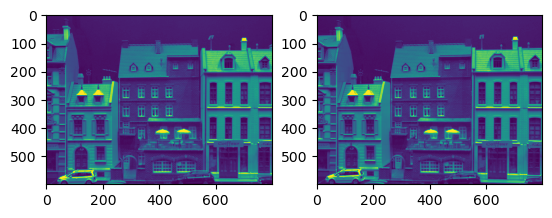

In [249]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1)
ax[1].imshow(im2)
plt.show()

In [250]:
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

# BFMatcher with default params
bf = cv2.BFMatcher_create(crossCheck=True) # cross checking
matches = bf.knnMatch(des1, des2, k=1)

# get non empty tuples
good_matches = []  
for m in matches:
    if m:
        good_matches.append(m[0])
        
# Sort them in the order of their distance. (get the best matches first)
#good_matches = sorted(good_matches, key = lambda x:x[0].distance)
    
# Find coordinates
pts_im1 = [kp1[m.queryIdx].pt for m in good_matches]
pts_im1 = np.array(pts_im1, dtype=np.float32).T
pts_im2 = [kp2[m.trainIdx].pt for m in good_matches]
pts_im2 = np.array(pts_im2, dtype=np.float32).T

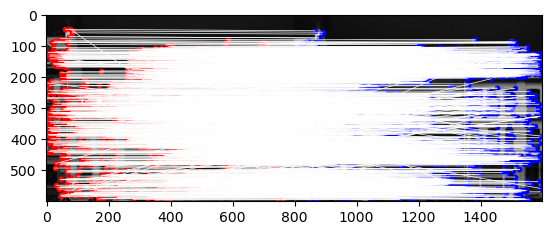

In [251]:
r1,c1 = im1.shape
r2,c2 = im2.shape
n_row = np.maximum(r1, r2)
n_col = c1 + c2
im_comp = np.zeros((n_row,n_col))
im_comp[:r1,:c1] = im1
im_comp[:r2,c1:(c1+c2)] = im2
    
fig,ax = plt.subplots(1)
ax.imshow(im_comp, cmap='gray')
ax.plot(pts_im1[0],pts_im1[1],'.r')
ax.plot(pts_im2[0]+c1,pts_im2[1],'.b')
ax.plot(np.c_[pts_im1[0],pts_im2[0]+c1].T,np.c_[pts_im1[1],pts_im2[1]].T,'w',linewidth = 0.5)

plt.show()

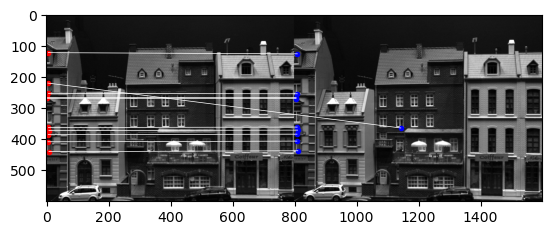

In [252]:
n = 10
fig,ax = plt.subplots(1)
ax.imshow(im_comp, cmap='gray')
ax.plot(pts_im1[0][0:n],pts_im1[1][0:n],'.r')
ax.plot(pts_im2[0][0:n]+c1,pts_im2[1][0:n],'.b')
ax.plot(np.c_[pts_im1[0][0:n],pts_im2[0][0:n]+c1].T,np.c_[pts_im1[1][0:n],pts_im2[1][0:n]].T,'w',linewidth = 0.5)

plt.show()

## Fundamental matrix estimation via RANSAC

In [253]:
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

def line(q1, q2):
    l = np.cross(q1, q2)
    l = l/np.sqrt(l[0]**2+l[1]**2)
    return l

def getinliers(Q, l, tau):
    Qh = Pi(Q)
    inliers = []
    outliers = []
    for i in range(Qh.shape[1]):
        d = abs(np.dot(l, Qh[:,i]))
        if d <= tau:
            inliers.append(Q[:,i])
        else:
            outliers.append(Q[:,i])
    inliers = np.array(inliers)
    outliers = np.array(outliers)
    return inliers, outliers

def consensus(Q, l, tau):
    inliers, outliers = getinliers(Q, l, tau)
    return len(inliers)

def draw(Q):
    Q = np.random.permutation(Q.T).T
    return Q[:,0], Q[:,1]

def pca_line(x): #assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l

def RANSAC(Q, tau):
    p = 0.99
    m = Q.shape[1]
    nmax_inliers = 0
    lfit = 0
    N = 0
    Nhat = 10
    while N <= Nhat:
        q1, q2 = draw(Q)
        l = line(Pi(q1), Pi(q2))
        n_inliers = consensus(Q, l, tau)
        if n_inliers > nmax_inliers:
            nmax_inliers = n_inliers
            lfit = l
        epshat = 1 - nmax_inliers/m
        Nhat = np.log(1-p)/np.log(1-(1-epshat)**2)
        N += 1
    inliers, outliers = getinliers(Q, lfit, tau)
    lfit = pca_line(inliers.T)
    return lfit, N

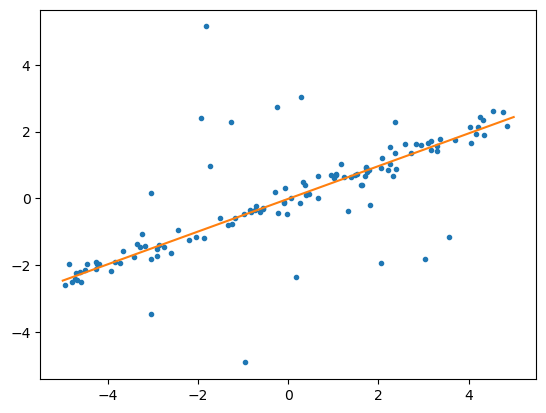

4


In [254]:
nin = 100
nout = 20 
Q = test_points(nin,nout)

l, nit = RANSAC(Q, 1)

x0 = -5
x1 = 5
y0 = - l[0]/l[1]*x0 - l[2]/l[1]
y1 = - l[0]/l[1]*x1 - l[2]/l[1]
n
plt.plot(Q[0,:], Q[1,:], '.')
plt.plot([x0, x1], [y0, y1])
plt.show()

print(nit)

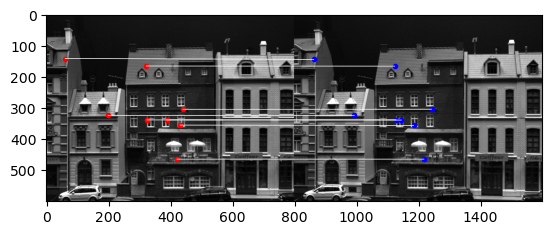

In [255]:
## sampled 8 points randomly 
    
sample = np.random.choice(good_matches, 8, replace=False)

# Find coordinates
p1 = [kp1[m.queryIdx].pt for m in sample]
p1 = np.array(p1, dtype=np.float32).T
p2 = [kp2[m.trainIdx].pt for m in sample]
p2 = np.array(p2, dtype=np.float32).T
    
fig,ax = plt.subplots(1)
ax.imshow(im_comp, cmap='gray')
ax.plot(p1[0],p1[1],'.r')
ax.plot(p2[0]+c1,p2[1],'.b')
ax.plot(np.c_[p1[0],p2[0]+c1].T,np.c_[p1[1],p2[1]].T,'w',linewidth = 0.5)

plt.show()

In [256]:
p1.shape

(2, 8)

In [257]:
## find F matrix 
F = Fest_8point(Pi(p1),Pi(p2))
F

array([[-3.82397511e-07,  7.07438553e-05, -2.14817862e-02],
       [-7.90427172e-05,  1.54482320e-06,  1.85139314e-01],
       [ 2.44647833e-02, -1.82766780e-01, -9.65017997e-01]])

In [258]:
## test
i = 0
a = Pi(p1)[:,i]
a.shape += (1,)
b = Pi(p2)[:,i]
b.shape += (1,)
b.T@F@a

array([[0.]])

In [259]:
def SampsonsDistance(F, p1, p2):
    a = p2.T@F
    a = a[0]
    b = F@p1
    d = (p2.T@F@p1)**2 / (a[0]**2 + a[1]**2 + b[0]**2 + b[1]**2)
    return d

In [260]:
thres = 3.84 * 3**2 # cf slide

p1inliers = [[],[]]
p2inliers = [[],[]]

for i in range(pts_im1.shape[1]):
    pi1 = Pi(pts_im1[:,i])
    pi1.shape += (1,)
    pi2 = Pi(pts_im2[:,i])
    pi2.shape += (1,)
    d = SampsonsDistance(F, pi1, pi2)
    if d < thres: #and (pi1[0][0] not in p1inliers[0] or pi1[1][0] not in p1inliers[1]) :
        p1inliers[0].append(pi1[0][0])
        p1inliers[1].append(pi1[1][0])
        p2inliers[0].append(pi2[0][0])
        p2inliers[1].append(pi2[1][0])

In [261]:
np.array(p2inliers).shape

(2, 1905)

In [262]:
np.array(p1inliers).shape

(2, 1905)

In [263]:
pts_im1.shape

(2, 2086)

In [264]:
#### repeat 200 times 

it = 200
thres = 3.84 * 3**2 # cf slide
nb_inliers_max = 0

for k in range(it):
    
    p1inliers = [[],[]]
    p2inliers = [[],[]]

    ## sampled 8 points randomly 
    sample = np.random.choice(good_matches, 8, replace=False)

    # Find coordinates
    p1 = [kp1[m.queryIdx].pt for m in sample]
    p1 = np.array(p1, dtype=np.float32).T
    p2 = [kp2[m.trainIdx].pt for m in sample]
    p2 = np.array(p2, dtype=np.float32).T
    
    ## find F matrix 
    F = Fest_8point(Pi(p1),Pi(p2))
    
    for i in range(pts_im1.shape[1]):
        pi1 = Pi(pts_im1[:,i])
        pi1.shape += (1,)
        pi2 = Pi(pts_im2[:,i])
        pi2.shape += (1,)
        d = SampsonsDistance(F, pi1, pi2)
        if d < thres :
            p1inliers[0].append(pi1[0][0])
            p1inliers[1].append(pi1[1][0])
            p2inliers[0].append(pi2[0][0])
            p2inliers[1].append(pi2[1][0])
            
    p1inliers = np.array(p1inliers)
    p2inliers = np.array(p2inliers)
    
    nb_inliers = p1inliers.shape[1]
    
    if nb_inliers > nb_inliers_max:
        nb_inliers_max = nb_inliers
        p1inliers_max = p1inliers
        p2inliers_max = p2inliers

In [265]:
p1inliers_max.shape

(2, 1929)

In [266]:
q1inliers = Pi(p1inliers_max)
q2inliers = Pi(p2inliers_max)

Ffinal = Fest_8point(q1inliers,q2inliers)
Ffinal

array([[-4.19278531e-07, -5.09916716e-06,  2.19917113e-03],
       [ 2.64299845e-08, -2.49474878e-06,  6.98596418e-02],
       [-1.66271046e-04, -6.60319643e-02, -9.95366539e-01]])

In [267]:
(Ffinal*Ftrue).sum() / (np.linalg.norm(Ffinal)*np.linalg.norm(Ftrue))
# shound be near 1

0.9931146726865895

In [268]:
Ffinal/Ffinal[0,0]*Ftrue[0,0]-Ftrue 

array([[ 0.00000000e+00,  8.66287202e-10, -1.52958005e-07],
       [ 9.75515912e-10,  4.46130837e-11, -3.39828865e-05],
       [-4.20857668e-07,  3.32223943e-05,  2.27859882e-04]])

In [269]:
q1inliers.shape

(3, 1929)

In [270]:
Ffinal/Ffinal[0,0]*Ftrue[0,0]

array([[ 6.67972386e-12,  8.12372351e-11, -3.50360317e-08],
       [-4.21068538e-13,  3.97450186e-11, -1.11296688e-06],
       [ 2.64894239e-09,  1.05198634e-06,  1.58576534e-05]])

In [271]:
Ftrue

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])